# Hyperparameter Tuning


In [1]:
import os
import pandas as pd

train_data_file = os.path.join('..', '..', '..', '..', 'data', 'raw', 'train.csv')
train_data = pd.read_csv(train_data_file, index_col=0, low_memory=False)

validation_data_file = os.path.join('..', '..', '..', '..', 'data', 'interim', 'all_test_4h.csv')
validation_data = pd.read_csv(validation_data_file, index_col=0, low_memory=False)

additional_train_data_file = os.path.join('..', '..', '..', '..', 'data', 'interim', 'all_test_3h.csv')
additional_train_data = pd.read_csv(additional_train_data_file, index_col=0, low_memory=False)
# remove from additional data patients that are not in validation data ids
additional_train_data = additional_train_data[~additional_train_data.index.isin(validation_data.index.unique())]

# merge train and additional data
train_data = pd.concat([train_data, additional_train_data], axis=0)

# do not train with patients that are not have to be predicted
test_data_file = os.path.join('..', '..', '..', '..', 'data', 'raw', 'test.csv')
test_data = pd.read_csv(test_data_file, index_col=0, low_memory=False)

unique_patients = test_data['p_num'].unique()
train_data = train_data[train_data['p_num'].isin(unique_patients)]
validation_data = validation_data[validation_data['p_num'].isin(unique_patients)]
test_data = test_data[test_data['p_num'].isin(unique_patients)]

train_data.head()

,p_num,time,bg-5:55,bg-5:50,bg-5:45,bg-5:40,bg-5:35,bg-5:30,bg-5:25,bg-5:20,...,activity-0:40,activity-0:35,activity-0:30,activity-0:25,activity-0:20,activity-0:15,activity-0:10,activity-0:05,activity-0:00,bg+1:00
id,,,,,,,,,,,,,,,,,,,,,
p01_0,p01,06:10:00,NaN,NaN,9.6,NaN,NaN,9.7,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.4
p01_1,p01,06:25:00,NaN,NaN,9.7,NaN,NaN,9.2,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.8
p01_2,p01,06:40:00,NaN,NaN,9.2,NaN,NaN,8.7,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.5
p01_3,p01,06:55:00,NaN,NaN,8.7,NaN,NaN,8.4,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.8
p01_4,p01,07:10:00,NaN,NaN,8.4,NaN,NaN,8.1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.7


In [2]:
from pipelines import pipeline

train_data = pipeline.fit_transform(train_data)
validation_data = pipeline.transform(validation_data)

In [3]:
X_train = train_data.drop(columns=['bg+1:00'])
y_train = train_data['bg+1:00']

X_test = validation_data.drop(columns=['bg+1:00'])
y_test = validation_data['bg+1:00']

### Define a tuning function

In [4]:
import joblib


def tune(tuner, X_train, y_train, X_test=None, y_test=None):
    print(f'-----------{tuner.__name__}-----------')
    print('Calculating best hyperparameters...')
    tuner.fit(X_train, y_train, X_test, y_test)
    print('Best hyperparameters found.')
    display(tuner.get_params())
    print(f'RMSE: {tuner.get_rmse()}')
    tuner.show_chart()
    joblib.dump(tuner.get_best_model(), f'{tuner.__name__}.model.pkl')

### Tune XGBoost

-----------XGBRegressor-----------
Calculating best hyperparameters...
Best hyperparameters found.


OrderedDict([('alpha', 0.0007592868338363518),
             ('colsample_bytree', 0.8406580906280636),
             ('gamma', 9),
             ('lambda', 2.3248800737612038e-08),
             ('learning_rate', 0.056219049628123706),
             ('max_depth', 8),
             ('min_child_weight', 4),
             ('n_estimators', 1000),
             ('scale_pos_weight', 1),
             ('subsample', 0.7639919695411114)])

RMSE: 1.3060079720572562


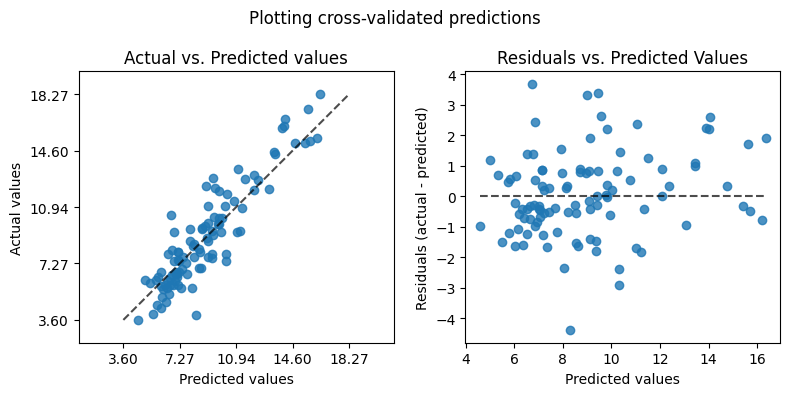

In [5]:
from src.features.tuners import XGBHyperparameterTuner

tune(XGBHyperparameterTuner(search_space='deep'), X_train, y_train, X_test, y_test)

## Tune HistGradientBoosting

-----------HistGradientBoostingRegressor-----------
Calculating best hyperparameters...
Best hyperparameters found.


OrderedDict([('early_stopping', False),
             ('l2_regularization', 1.0),
             ('learning_rate', 0.09139428753288206),
             ('max_bins', 255),
             ('max_depth', 15),
             ('max_iter', 500),
             ('max_leaf_nodes', 31),
             ('min_samples_leaf', 50),
             ('scoring', 'neg_mean_squared_error')])

RMSE: 1.792197011623137


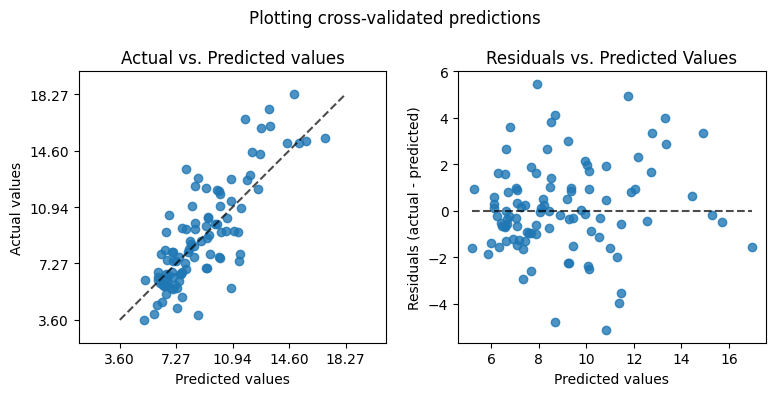

In [6]:
from src.features.tuners import HistGradientBoostingHyperparameterTuner

tune(HistGradientBoostingHyperparameterTuner(), X_train, y_train, X_test, y_test)

### Tune LassoLarsIC

-----------LassoLarsIC-----------
Calculating best hyperparameters...


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Best hyperparameters found.


OrderedDict([('criterion', 'bic'),
             ('eps', 1.000000000000016e-05),
             ('max_iter', 5000),
             ('noise_variance', 0.01),
             ('positive', False)])

RMSE: 2.2338550963020634


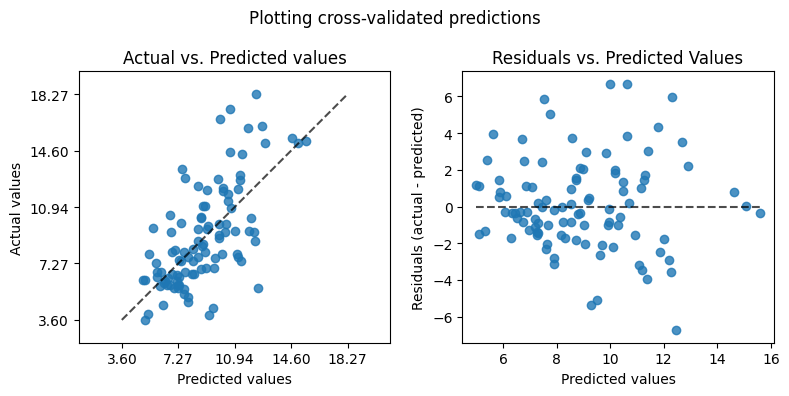

In [7]:
from src.features.tuners import LassoLarsICHyperparameterTuner

tune(LassoLarsICHyperparameterTuner(), X_train, y_train, X_test, y_test)